# CNN

In [88]:
%pylab inline
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
import h5py
import numpy as np

tile_size = 28

Populating the interactive namespace from numpy and matplotlib


## Import data

In [68]:
h5py
hdf5_path = "scaffan_dataset.hdf5"
# open a hdf5 file and create earrays
hdf5_file = h5py.File(hdf5_path, mode='r')
X = hdf5_file["X"][()]
y = hdf5_file["y"][()]

In [25]:
print(f"X: {X.dtype} {X.shape}, min/max: {(np.min(X), np.max(X))}")
print(f"y: {y.dtype} {y.shape}, unique: {np.unique(y)}")

X: float64 (1882, 28, 28, 1), min/max: (0.2395357780297619, 0.9104676371894007)
y: int32 (1882,), unique: [1 2]


In [26]:
y = to_categorical(y)
import sklearn.model_selection
# sklearn.train_test_split
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.33)

In [36]:
display(np.unique(y_test, return_counts=True))
display(np.unique(y_train, return_counts=True))

(array([0., 1.], dtype=float32), array([1244,  622], dtype=int64))

(array([0., 1.], dtype=float32), array([2520, 1260], dtype=int64))

## Model

In [40]:

#create model
model = Sequential()
#add model layersfrom keras.models import Sequential
model.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
# model.add(Dense(10, activation='softmax'))

In [41]:
#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [42]:
#train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)

Train on 1260 samples, validate on 622 samples
Epoch 1/3
  96/1260 [=>............................] - ETA: 26s - loss: 1.1320 - acc: 0.37 - ETA: 22s - loss: 0.9834 - acc: 0.4896

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.241335). Check your callbacks.
  % delta_t_median)
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.271239). Check your callbacks.
  % delta_t_median)


 288/1260 [=====>........................] - ETA: 13s - loss: 0.7685 - acc: 0.6181

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.211432). Check your callbacks.
  % delta_t_median)
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.209436). Check your callbacks.
  % delta_t_median)


 352/1260 [=======>......................] - ETA: 12s - loss: 0.7352 - acc: 0.6420

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210433). Check your callbacks.
  % delta_t_median)
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.210933). Check your callbacks.
  % delta_t_median)


 416/1260 [========>.....................] - ETA: 11s - loss: 0.7206 - acc: 0.6514

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.216419). Check your callbacks.
  % delta_t_median)


 448/1260 [=========>....................] - ETA: 10s - loss: 0.7076 - acc: 0.6607

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.208937). Check your callbacks.
  % delta_t_median)


 512/1260 [===========>..................] - ETA: 10s - loss: 0.7009 - acc: 0.66

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.254331). Check your callbacks.
  % delta_t_median)


 608/1260 [=============>................] - ETA: 8s - loss: 0.6896 - acc: 0.6743

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.270288). Check your callbacks.
  % delta_t_median)
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.281757). Check your callbacks.
  % delta_t_median)


 640/1260 [==============>...............] - ETA: 8s - loss: 0.6837 - acc: 0.6781

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.287744). Check your callbacks.
  % delta_t_median)


 736/1260 [================>.............] - ETA: 7s - loss: 0.6891 - acc: 0.6807

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.300688). Check your callbacks.
  % delta_t_median)
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.299203). Check your callbacks.
  % delta_t_median)


 832/1260 [==================>...........] - ETA: 5s - loss: 0.6917 - acc: 0.6779

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.285264). Check your callbacks.
  % delta_t_median)
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.280763). Check your callbacks.
  % delta_t_median)


 896/1260 [====================>.........] - ETA: 4s - loss: 0.6920 - acc: 0.6641

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.300213). Check your callbacks.
  % delta_t_median)


1056/1260 [========================>.....] - ETA: 2s - loss: 0.6875 - acc: 0.6629

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.282261). Check your callbacks.
  % delta_t_median)


1152/1260 [==========================>...] - ETA: 1s - loss: 0.6823 - acc: 0.6658

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.275265). Check your callbacks.
  % delta_t_median)


1216/1260 [===========================>..] - ETA: 0s - loss: 0.6735 - acc: 0.6727

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.245839). Check your callbacks.
  % delta_t_median)
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240853). Check your callbacks.
  % delta_t_median)


1248/1260 [============================>.] - ETA: 0s - loss: 0.6755 - acc: 0.6723

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.219921). Check your callbacks.
  % delta_t_median)
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.215410). Check your callbacks.
  % delta_t_median)


1260/1260 [==============================] - 18s 14ms/step - loss: 0.6735 - acc: 0.6738 - val_loss: 0.6935 - val_acc: 0.6977
Epoch 2/3
  96/1260 [=>............................] - ETA: 9s - loss: 0.4630 - acc: 0.8333

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.157568). Check your callbacks.
  % delta_t_median)
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.171055). Check your callbacks.
  % delta_t_median)


 160/1260 [==>...........................] - ETA: 11s - loss: 0.6171 - acc: 0.7375

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.184542). Check your callbacks.
  % delta_t_median)
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.192510). Check your callbacks.
  % delta_t_median)


 224/1260 [====>.........................] - ETA: 11s - loss: 0.6279 - acc: 0.7232

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.186500). Check your callbacks.
  % delta_t_median)
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.193489). Check your callbacks.
  % delta_t_median)


 288/1260 [=====>........................] - ETA: 10s - loss: 0.6391 - acc: 0.7083

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.197471). Check your callbacks.
  % delta_t_median)
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.198974). Check your callbacks.
  % delta_t_median)


 352/1260 [=======>......................] - ETA: 10s - loss: 0.6500 - acc: 0.6903

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.200478). Check your callbacks.
  % delta_t_median)
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.202451). Check your callbacks.
  % delta_t_median)


 416/1260 [========>.....................] - ETA: 9s - loss: 0.6525 - acc: 0.6899

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.238366). Check your callbacks.
  % delta_t_median)
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.253840). Check your callbacks.
  % delta_t_median)


 512/1260 [===========>..................] - ETA: 8s - loss: 0.6530 - acc: 0.6875

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.225399). Check your callbacks.
  % delta_t_median)


 608/1260 [=============>................] - ETA: 7s - loss: 0.6493 - acc: 0.6891

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.249350). Check your callbacks.
  % delta_t_median)


 704/1260 [===============>..............] - ETA: 6s - loss: 0.6482 - acc: 0.6889

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233377). Check your callbacks.
  % delta_t_median)


 768/1260 [=================>............] - ETA: 5s - loss: 0.6410 - acc: 0.6953

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247355). Check your callbacks.
  % delta_t_median)
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.268798). Check your callbacks.
  % delta_t_median)


 864/1260 [===================>..........] - ETA: 4s - loss: 0.6396 - acc: 0.6956

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.256318). Check your callbacks.
  % delta_t_median)


 928/1260 [=====================>........] - ETA: 3s - loss: 0.6325 - acc: 0.7037

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240345). Check your callbacks.
  % delta_t_median)


 992/1260 [======================>.......] - ETA: 3s - loss: 0.6305 - acc: 0.7046

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.233380). Check your callbacks.
  % delta_t_median)
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.258313). Check your callbacks.
  % delta_t_median)


1056/1260 [========================>.....] - ETA: 2s - loss: 0.6334 - acc: 0.7008

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.232366). Check your callbacks.
  % delta_t_median)
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.239348). Check your callbacks.
  % delta_t_median)


1184/1260 [===========================>..] - ETA: 0s - loss: 0.6274 - acc: 0.7061

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222406). Check your callbacks.
  % delta_t_median)


1216/1260 [===========================>..] - ETA: 0s - loss: 0.6284 - acc: 0.7048

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.229370). Check your callbacks.
  % delta_t_median)


1248/1260 [============================>.] - ETA: 0s - loss: 0.6270 - acc: 0.7059

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.222405). Check your callbacks.
  % delta_t_median)


1260/1260 [==============================] - 16s 13ms/step - loss: 0.6272 - acc: 0.7056 - val_loss: 0.6229 - val_acc: 0.6977
Epoch 3/3
  64/1260 [>.............................] - ETA: 8s - loss: 0.5270 - acc: 0.7969

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.170549). Check your callbacks.
  % delta_t_median)
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.223903). Check your callbacks.
  % delta_t_median)


 128/1260 [==>...........................] - ETA: 11s - loss: 0.5562 - acc: 0.7656

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.194519). Check your callbacks.
  % delta_t_median)
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.235888). Check your callbacks.
  % delta_t_median)


 192/1260 [===>..........................] - ETA: 13s - loss: 0.5925 - acc: 0.7344

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.277256). Check your callbacks.
  % delta_t_median)
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.247338). Check your callbacks.
  % delta_t_median)


 320/1260 [======>.......................] - ETA: 11s - loss: 0.6002 - acc: 0.7250

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.290224). Check your callbacks.
  % delta_t_median)


 384/1260 [========>.....................] - ETA: 11s - loss: 0.6089 - acc: 0.7135

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.258309). Check your callbacks.
  % delta_t_median)
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.276261). Check your callbacks.
  % delta_t_median)


 448/1260 [=========>....................] - ETA: 10s - loss: 0.6106 - acc: 0.7143

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.257313). Check your callbacks.
  % delta_t_median)
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.289228). Check your callbacks.
  % delta_t_median)


 480/1260 [==========>...................] - ETA: 10s - loss: 0.6109 - acc: 0.7146

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.267285). Check your callbacks.
  % delta_t_median)


 576/1260 [============>.................] - ETA: 9s - loss: 0.6192 - acc: 0.7031

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.273768). Check your callbacks.
  % delta_t_median)


 736/1260 [================>.............] - ETA: 6s - loss: 0.6258 - acc: 0.6943

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.274765). Check your callbacks.
  % delta_t_median)


 768/1260 [=================>............] - ETA: 6s - loss: 0.6268 - acc: 0.6927

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.267298). Check your callbacks.
  % delta_t_median)


 864/1260 [===================>..........] - ETA: 5s - loss: 0.6299 - acc: 0.6887

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.297205). Check your callbacks.
  % delta_t_median)
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.293216). Check your callbacks.
  % delta_t_median)


 960/1260 [=====================>........] - ETA: 4s - loss: 0.6266 - acc: 0.6948

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.280765). Check your callbacks.
  % delta_t_median)


1024/1260 [=======================>......] - ETA: 3s - loss: 0.6262 - acc: 0.6953

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.264310). Check your callbacks.
  % delta_t_median)
C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.253337). Check your callbacks.
  % delta_t_median)


1120/1260 [=========================>....] - ETA: 1s - loss: 0.6225 - acc: 0.7000

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.286750). Check your callbacks.
  % delta_t_median)


1184/1260 [===========================>..] - ETA: 1s - loss: 0.6211 - acc: 0.7019

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231363). Check your callbacks.
  % delta_t_median)


1248/1260 [============================>.] - ETA: 0s - loss: 0.6175 - acc: 0.7059

C:\Users\Jirik\Miniconda3\envs\scaffan\lib\site-packages\keras\callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.240860). Check your callbacks.
  % delta_t_median)


1260/1260 [==============================] - 18s 14ms/step - loss: 0.6177 - acc: 0.7056 - val_loss: 0.6210 - val_acc: 0.6977


## Predict

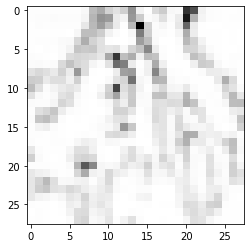

In [66]:
plt.imshow(X_test[-116].reshape(28,28), cmap='gray')

1


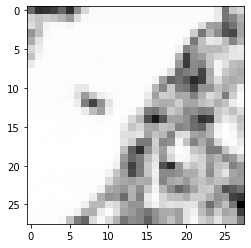

In [75]:
i = -200
plt.imshow(X[i,:,:,0], cmap="gray")
print(y[i])

In [110]:
np.max(np.argmax(model.predict(X_test[:]), axis=1))

1

# Image segmentation 

In [84]:
from pathlib import Path
path_to_script =  Path("~/projects/scaffan/").expanduser()
sys.path.insert(0,str(path_to_script))
import scaffan
import scaffan.image as scim
import io3d

pixelsize_mm = [0.004, 0.004]

fn = io3d.datasets.join_path("medical/orig/Scaffan-analysis/PIG-003_J-18-0165_HE.ndpi", get_root=True)
anim = scim.AnnotatedImage(fn)
#
ann_ids = anim.select_annotations_by_color("#000000")
print(ann_ids)
view = anim.get_views(ann_ids, pixelsize_mm=pixelsize_mm)[0]

2019-07-10 08:50:42.390 | DEBUG    | scaffan.image:__init__:166 - Reading file C:\Users\Jirik/data/medical/orig/Scaffan-analysis/PIG-003_J-18-0165_HE.ndpi
2019-07-10 08:50:42.639 | DEBUG    | scaffan.image:__init__:180 - Reading the annotation
2019-07-10 08:50:44.454 | DEBUG    | scaffan.annotation:read_annotations:112 - windows annotation output:b'2019-07-10 08:50:44.294 | DEBUG    | scaffan.annotation:ndpa_to_json:64 - PATH: C:\\Users\\Jirik\\Miniconda3\\envs\\scaffan\\Library\\bin;C:\\Users\\Jirik\\Downloads\\openslide-win64-20171122\\bin;C:\\Users\\Jirik\\Miniconda3\\envs\\scaffan\\Library\\bin;C:\\Users\\Jirik\\Miniconda3\\envs\\scaffan\\Library\\bin;C:\\Users\\Jirik\\Miniconda3\\envs\\scaffan\\Library\\bin;C:\\Users\\Jirik\\Miniconda3\\envs\\scaffan;C:\\Users\\Jirik\\Miniconda3\\envs\\scaffan\\Library\\mingw-w64\\bin;C:\\Users\\Jirik\\Miniconda3\\envs\\scaffan\\Library\\usr\\bin;C:\\Users\\Jirik\\Miniconda3\\envs\\scaffan\\Library\\bin;C:\\Users\\Jirik\\Miniconda3\\envs\\scaffan\

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


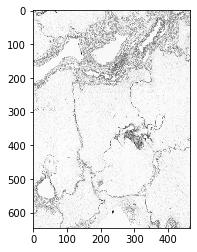

In [85]:
img = view.get_region_image(as_gray=True)
plt.imshow(img, cmap="gray")

In [87]:
seg = np.zeros_like(img, dtype=np.uint8)

In [106]:
for ind0 in range(0, seg.shape[0], tile_size):
    for ind1 in range(0, seg.shape[1], tile_size):
        sl1 = slice(ind0, (ind0+tile_size))
        sl2 = slice(ind1, (ind1+tile_size))
#         print(sl1, sl2)
        img0 = img[sl1,sl2]
        if img0.shape == (tile_size, tile_size):
            img0ok = img0
            pr = model.predict(img0ok.reshape(1,tile_size, tile_size, 1))
            val = np.argmax(pr)
            seg[sl1, sl2] = val
            
        

In [100]:
# img0ok.shape == (tile_size, tile_size)

True

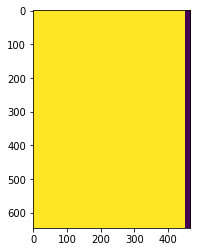

In [107]:
plt.imshow(seg)

1